In [88]:
pip install azure-storage-file-datalake pandas pyarrow openpyxl xlrd networkx matplotlib


  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     ------------------------------------  163.8/165.5 kB 10.2 MB/s eta 0:00:01
     ------------------------------------  163.8/165.5 kB 10.2 MB/s eta 0:00:01
     -------------------------------------- 165.5/165.5 kB 1.7 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------- -------------------------------- 0.4/2.2 MB 12.6 MB/s eta 0:00:01
   

In [66]:
from azure.storage.filedatalake import DataLakeServiceClient
from io import BytesIO

account_name = "adlsidd01"
sas_token = "sv=2022-11-02&ss=bf&srt=co&se=2024-07-07T00%3A20%3A46Z&sp=rwl&sig=AuATst3cPKuwswgyUsSVQZfKwZT9p8GyMEOhUiGDLCQ%3D"
file_system_name = "morongo"  # This is your file system name
directory_name = "deltalake/PassportIQ/bronze/"  # The directory you want to list files from

service_client = DataLakeServiceClient(account_url=f"https://{account_name}.dfs.core.windows.net", credential=sas_token)

file_system_client = service_client.get_file_system_client(file_system_name)

# List paths in the specified directory
paths = file_system_client.get_paths(path=directory_name)

dataframes = []
paths = file_system_client.get_paths(path=directory_name) 
for path in paths:
    file_path = path.name  # Ensure you are using the correct file path from the directory listing
    print(f"Attempting to download: {file_path}")
    
    try:
        file_client = file_system_client.get_file_client(file_path)
        download = file_client.download_file()
        downloaded_bytes = download.readall()
        print(f"Successfully downloaded: {file_path}")
        if file_path.endswith(".xlsx"):
            df = pd.read_excel(BytesIO(downloaded_bytes), engine='openpyxl',skiprows=3)
        elif file_path.endswith(".xls"):
            df = pd.read_excel(BytesIO(downloaded_bytes), engine='xlrd',skiprows=3)
        
        # Convert the 'Session' column to numeric, forcing errors to NaN
        df['Session'] = pd.to_numeric(df['Session'], errors='coerce')
            
        # Filter out rows where 'Session' is NaN (non-numeric)
        df = df.dropna(subset=['Session'])

        dataframes.append(df)
        print(f"Successfully downloaded and read: {file_path}")
    except Exception as e:
        print(f"Error downloading {file_path}: {str(e)}")

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    for col in combined_df.columns:
        combined_df[col] = combined_df[col].astype(str)
    combined_df.rename(columns=lambda x: x.strip().replace(' ', '_').replace('.', '').replace('/', '_'), inplace=True)


    # Save the combined DataFrame as a Parquet file
    parquet_file_path = "combined_data.parquet"
    combined_df.to_parquet(parquet_file_path, engine='pyarrow')
    print(f"Successfully saved combined DataFrame to '{parquet_file_path}'")
else:
    print("No Excel files found to process.")




Attempting to download: deltalake/PassportIQ/bronze/CASTransactionSummary Aug 01 2023- Aug 20 2023.xls
Successfully downloaded: deltalake/PassportIQ/bronze/CASTransactionSummary Aug 01 2023- Aug 20 2023.xls
Successfully downloaded and read: deltalake/PassportIQ/bronze/CASTransactionSummary Aug 01 2023- Aug 20 2023.xls
Attempting to download: deltalake/PassportIQ/bronze/CASTransactionSummary Aug 20 2023- Aug 31 2023.xls
Successfully downloaded: deltalake/PassportIQ/bronze/CASTransactionSummary Aug 20 2023- Aug 31 2023.xls
Successfully downloaded and read: deltalake/PassportIQ/bronze/CASTransactionSummary Aug 20 2023- Aug 31 2023.xls
Attempting to download: deltalake/PassportIQ/bronze/CASTransactionSummary July 01 2023-July 20 2023.xls
Successfully downloaded: deltalake/PassportIQ/bronze/CASTransactionSummary July 01 2023-July 20 2023.xls
Successfully downloaded and read: deltalake/PassportIQ/bronze/CASTransactionSummary July 01 2023-July 20 2023.xls
Attempting to download: deltalake/Pas

In [68]:
parquet_file_path = "combined_data.parquet"

df = pd.read_parquet(parquet_file_path, engine='pyarrow')
empty_card_check_no_df = df[df['Card_Check_No'].isna() | (df['Card_Check_No'] == '')]

# Print the filtered DataFrame
print(len(empty_card_check_no_df))
df['Card_Check_No'].tail(10)


0


145956    434256******9735
145957    440393******8485
145958    511015******7389
145959    434769******2633
145960    440393******8485
145961    424631******1591
145962    434256******3811
145963    440393******8485
145964    436618******5452
145965    424631******1591
Name: Card_Check_No, dtype: object

In [69]:
df.to_csv('combined_data1.csv', index=False)

In [85]:
import pandas as pd
import numpy as np

# Load the data
file_path = 'combined_data1.csv'
data = pd.read_csv(file_path)

# Node DataFrames
data.dropna(subset=['Card_Check_No','Trans_Type','Trans_Type'], inplace=True)
data= data[data['Card_Check_No'].str.contains('^[0-9]')]

customer_nodes = data[['Card_Check_No']].drop_duplicates().reset_index(drop=True)
customer_nodes['Node_Type'] = 'Customer'

# Unique transaction types
transaction_type_nodes = data[['Trans_Type']].drop_duplicates().reset_index(drop=True)
transaction_type_nodes['Node_Type'] = 'Transaction_Type'

# Unique card check types
card_check_type_nodes = data[['Card_Check_Type']].drop_duplicates().reset_index(drop=True)
card_check_type_nodes['Node_Type'] = 'Card_Check_Type'

# Node DataFrame
nodes = pd.concat([customer_nodes, 
                   transaction_type_nodes.rename(columns={'Trans_Type': 'Card_Check_No'}),
                   card_check_type_nodes.rename(columns={'Card_Check_Type': 'Card_Check_No'})],
                  ignore_index=True)

# Edge DataFrames
# Customer-Transaction Type Edges
customer_transaction_edges = data.groupby(['Card_Check_No', 'Trans_Type']).agg(
    Frequency=('Trans_Type', 'size'),
    Total_Amount=('Amount', 'sum'),
    Average_Amount=('Amount', 'mean')
).reset_index()
customer_transaction_edges['Edge_Type'] = 'Customer-Transaction_Type'

# Customer-Card Check Type Edges
customer_card_check_edges = data.groupby(['Card_Check_No', 'Card_Check_Type']).agg(
    Frequency=('Card_Check_Type', 'size'),
    Total_Amount=('Amount', 'sum'),
    Average_Amount=('Amount', 'mean')
).reset_index()
customer_card_check_edges['Edge_Type'] = 'Customer-Card_Check_Type'

# Edge DataFrame
edges = pd.concat([customer_transaction_edges, customer_card_check_edges], ignore_index=True)

#nodes.head(), edges.head()

edges.head(30)


,Card_Check_No,Trans_Type,Frequency,Total_Amount,Average_Amount,Edge_Type,Card_Check_Type
0,000397,Check,1,100.0,100.0,Customer-Transaction_Type,NaN
1,000478,Check,1,400.0,400.0,Customer-Transaction_Type,NaN
2,00141,Check,1,300.0,300.0,Customer-Transaction_Type,NaN
3,00143,Check,1,300.0,300.0,Customer-Transaction_Type,NaN
4,001463,Check,1,100.0,100.0,Customer-Transaction_Type,NaN
5,00184,Check,1,100.0,100.0,Customer-Transaction_Type,NaN
6,00186,Check,1,400.0,400.0,Customer-Transaction_Type,NaN
7,00197,Check,1,200.0,200.0,Customer-Transaction_Type,NaN
8,00209,Check,1,100.0,100.0,Customer-Transaction_Type,NaN
9,00233,Check,1,200.0,200.0,Customer-Transaction_Type,NaN


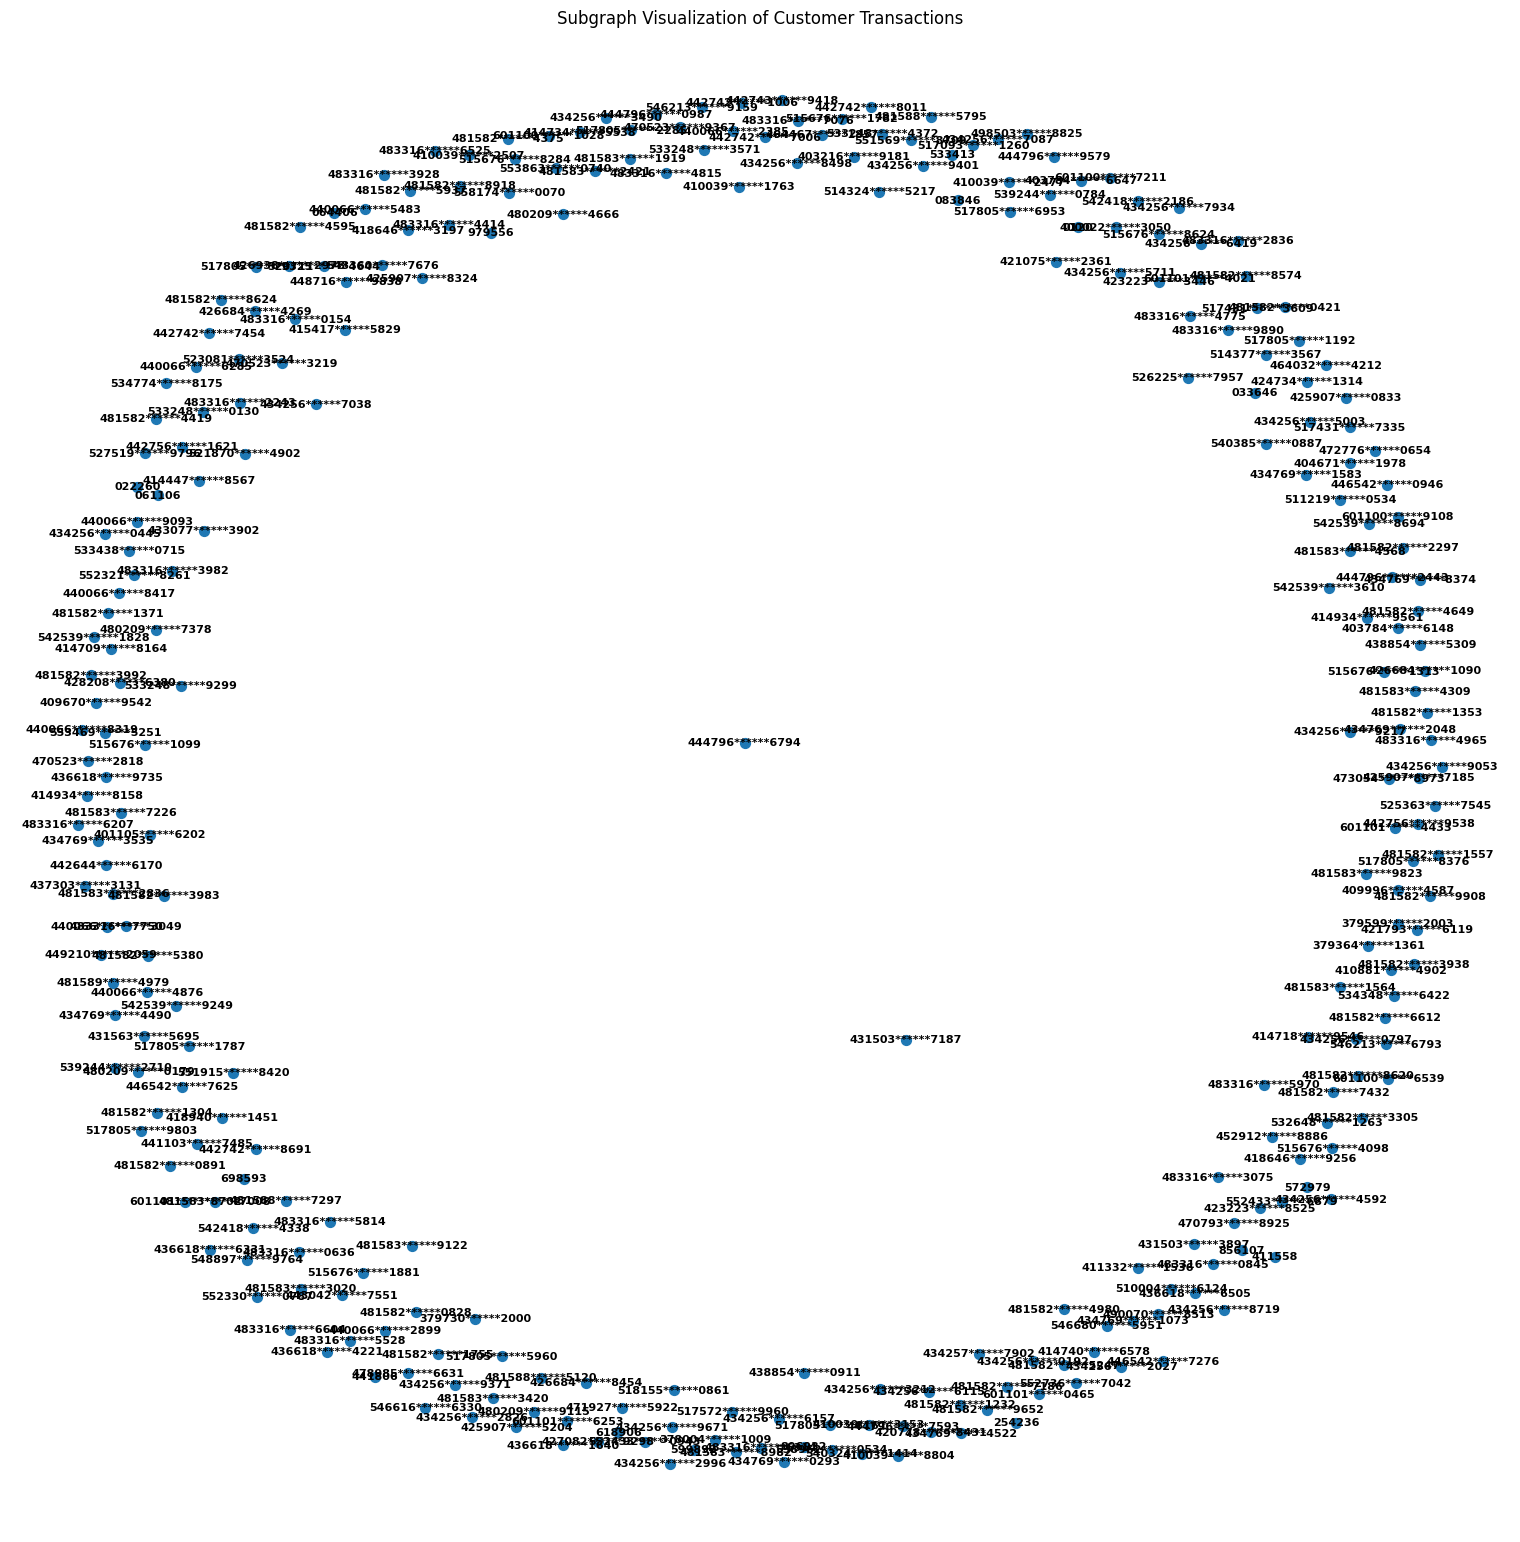

In [103]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the graph using NetworkX
G = nx.Graph()

# Add nodes
for index, row in nodes.iterrows():
    G.add_node(row['Card_Check_No'], Node_Type=row['Node_Type'])

# Add edges
for index, row in edges.iterrows():
    if row['Edge_Type'] == 'Customer-Transaction_Type':
        G.add_edge(row['Card_Check_No'], row['Trans_Type'], Frequency=row['Frequency'], 
                   Total_Amount=row['Total_Amount'], Average_Amount=row['Average_Amount'], 
                   Edge_Type=row['Edge_Type'])
    elif row['Edge_Type'] == 'Customer-Card_Check_Type':
        G.add_edge(row['Card_Check_No'], row['Card_Check_Type'], Frequency=row['Frequency'], 
                   Total_Amount=row['Total_Amount'], Average_Amount=row['Average_Amount'], 
                   Edge_Type=row['Edge_Type'])

# Visualize the graph
# Create a subgraph with a limited number of nodes
subgraph = G.subgraph(list(G.nodes)[:300])  # Limiting to the first 200 nodes for visualization

# Draw the subgraph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(subgraph, seed=42)  # Position nodes using the spring layout

nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, font_weight='bold')
plt.title("Subgraph Visualization of Customer Transactions")
plt.show()

In [92]:
# Export the graph to GraphML
nx.write_graphml(G, "directed_graph.graphml")

# Export the graph to GEXF
nx.write_gexf(G, "directed_graph.gexf")

In [104]:
nx.degree_histogram(G)

[0,
 0,
 48426,
 2937,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 